In [59]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models, initializers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

class TableGAN:
    def __init__(self, input_dim, generator_dims, discriminator_dims):
        self.input_dim = input_dim
        self.generator_dims = generator_dims
        self.discriminator_dims = discriminator_dims
        self.generator = self._make_generator_model()
        self.discriminator = self._make_discriminator_model()
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)
        self.scaler = MinMaxScaler()
        self.onehot_encoder = OneHotEncoder(sparse_output=False)

    def _make_generator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Input(shape=(self.input_dim,)))
        for dim in self.generator_dims:
            model.add(layers.Dense(dim, use_bias=False, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
            model.add(layers.BatchNormalization())
            model.add(layers.ReLU())
        model.add(layers.Dense(self.input_dim, activation='tanh', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        return model

    def _make_discriminator_model(self):
        model = tf.keras.Sequential()
        for dim in self.discriminator_dims:
            if len(model.layers) == 0:
                model.add(layers.Dense(dim, input_shape=(self.input_dim,), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
            else:
                model.add(layers.Dense(dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
            model.add(layers.LeakyReLU(0.2))
            model.add(layers.Dropout(0.3))
        model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        return model

    def _warmup_run(self, x, y, epochs=1):
        lr_model = LogisticRegression(max_iter=1000)
        lr_model.fit(x, y)
        return lr_model.coef_, lr_model.intercept_

    @tf.function
    def train_step(self, real_data):
        noise = tf.random.normal([tf.shape(real_data)[0], self.input_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(noise, training=True)
            
            real_output = self.discriminator(real_data, training=True)
            fake_output = self.discriminator(generated_data, training=True)
            
            gen_loss = -tf.reduce_mean(fake_output)
            disc_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
            
            # Add gradient penalty
            epsilon = tf.random.uniform([tf.shape(real_data)[0], 1], 0.0, 1.0)
            interpolated = epsilon * real_data + (1 - epsilon) * generated_data
            with tf.GradientTape() as gp_tape:
                gp_tape.watch(interpolated)
                interpolated_output = self.discriminator(interpolated, training=True)
            grads = gp_tape.gradient(interpolated_output, [interpolated])[0]
            norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1]))
            gp = tf.reduce_mean((norm - 1.0) ** 2)
            disc_loss += 10 * gp

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return gen_loss, disc_loss

    def fit(self, x, y, epochs=100, batch_size=32, warmup_epochs=1, verbose=0):
        # Handle NaN values in x
        imputer_x = SimpleImputer(strategy='mean')
        x_imputed = imputer_x.fit_transform(x)
        
        # Handle NaN values in y
        imputer_y = SimpleImputer(strategy='most_frequent')
        y_imputed = imputer_y.fit_transform(y.reshape(-1, 1)).ravel()

        x_scaled = self.scaler.fit_transform(x_imputed).astype(np.float32)
        y_encoded = self.onehot_encoder.fit_transform(y_imputed.reshape(-1, 1)).astype(np.float32)
        
        # Warm-up phase
        if verbose:
            print("Warm-up phase:")
        warmup_weights, warmup_bias = self._warmup_run(x_scaled, y_imputed, warmup_epochs)
        
        # Initialize part of the generator's final layer with warm-up weights
        gen_final_layer = self.generator.layers[-1]
        current_weights, current_bias = gen_final_layer.get_weights()
        
        # Adjust the warm-up weights to match the shape of the generator's final layer
        adjusted_warmup_weights = np.zeros_like(current_weights)
        adjusted_warmup_weights[:warmup_weights.shape[1], :warmup_weights.shape[0]] = warmup_weights.T
        
        # Combine the adjusted warm-up weights with the existing weights
        new_weights = 0.5 * current_weights + 0.5 * adjusted_warmup_weights
        
        new_bias = current_bias.copy()
        new_bias[:warmup_bias.shape[0]] = warmup_bias
        gen_final_layer.set_weights([new_weights, new_bias])

        dataset = tf.data.Dataset.from_tensor_slices((x_scaled, y_encoded)).shuffle(buffer_size=1000).batch(batch_size)

        for epoch in range(epochs):
            for batch_data, _ in dataset:
                gen_loss, disc_loss = self.train_step(batch_data)
                if verbose:
                    print(f"Epoch {epoch+1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

    def generate(self, n_samples):
        noise = tf.random.normal([n_samples, self.input_dim])
        generated_data = self.generator(noise, training=False)
        generated_data_scaled = self.scaler.inverse_transform(generated_data.numpy())
        return np.clip(generated_data_scaled, 0, 1)  # Clip values between 0 and 1

    def evaluate(self, x, y, model='lr'):
        from sklearn.linear_model import LogisticRegression
        from sklearn.neural_network import MLPClassifier
        from sklearn.ensemble import RandomForestClassifier
        
        models = {
            'lr': LogisticRegression,
            'mlp': MLPClassifier,
            'rf': RandomForestClassifier
        }
        
        if model not in models:
            raise ValueError("Invalid model. Choose from 'lr', 'mlp', or 'rf'.")
        
        eval_model = models[model]()
        
        synthetic_data = self.generate(len(x))
        synthetic_x, synthetic_y = synthetic_data[:, :-1], synthetic_data[:, -1]
        
        eval_model.fit(synthetic_x, synthetic_y)
        y_pred = eval_model.predict(x)
        
        return accuracy_score(y, y_pred)

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the datasets
features = pd.read_csv('train_Adult_cleaned.csv')
labels = pd.read_csv('train_Adult_labels.csv')

# Assuming labels are in a single column and the rows correspond to the features
data = pd.concat([features, labels], axis=1)

# Preprocess the dataset
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data_scaled, test_size=0.2, random_state=42)

In [53]:
train_data.shape

(1600, 15)

In [61]:
# Determine the number of features (excluding the label column if it's included)
input_dim = train_data.shape[1] - 1  # This should be 14
generator_dims = [128, 256, 512]
discriminator_dims = [512, 256, 128]

# Initialize the TableGAN model
tablegan = TableGAN(input_dim, generator_dims, discriminator_dims)

# Prepare your data
X = train_data[:, :-1]  # Features (should be shape (1600, 14))
y = train_data[:, -1]   # Labels (should be shape (1600,))

# Train the model
tablegan.fit(X, y, epochs=20, batch_size=32, warmup_epochs=1, verbose=1)

# Generate synthetic data
synthetic_data = tablegan.generate(1000)

# Evaluate the model
evaluation_score = tablegan.evaluate(X, y, model='lr')
print(f"Evaluation score: {evaluation_score}")

c:\Users\tahat\anaconda3\envs\chatbot\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Warm-up phase:
Epoch 1, Generator Loss: -0.5000630021095276, Discriminator Loss: 9.992368698120117
Epoch 1, Generator Loss: -0.5000796318054199, Discriminator Loss: 9.992104530334473
Epoch 1, Generator Loss: -0.500055730342865, Discriminator Loss: 9.99273681640625
Epoch 1, Generator Loss: -0.5000489950180054, Discriminator Loss: 9.99250602722168
Epoch 1, Generator Loss: -0.5000627040863037, Discriminator Loss: 9.992541313171387
Epoch 1, Generator Loss: -0.5000782012939453, Discriminator Loss: 9.992025375366211
Epoch 1, Generator Loss: -0.5000792741775513, Discriminator Loss: 9.992410659790039
Epoch 1, Generator Loss: -0.5000555515289307, Discriminator Loss: 9.992036819458008
Epoch 1, Generator Loss: -0.5000478029251099, Discriminator Loss: 9.992213249206543
Epoch 1, Generator Loss: -0.5000741481781006, Discriminator Loss: 9.992563247680664
Epoch 1, Generator Loss: -0.5000461339950562, Discriminator Loss: 9.991708755493164
Epoch 1, Generator Loss: -0.500052273273468, Discriminator Loss:

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [9]:
# Generate synthetic data
n_samples = len(test_data)  # Number of samples to generate
synthetic_data = tablegan.generate(n_samples)

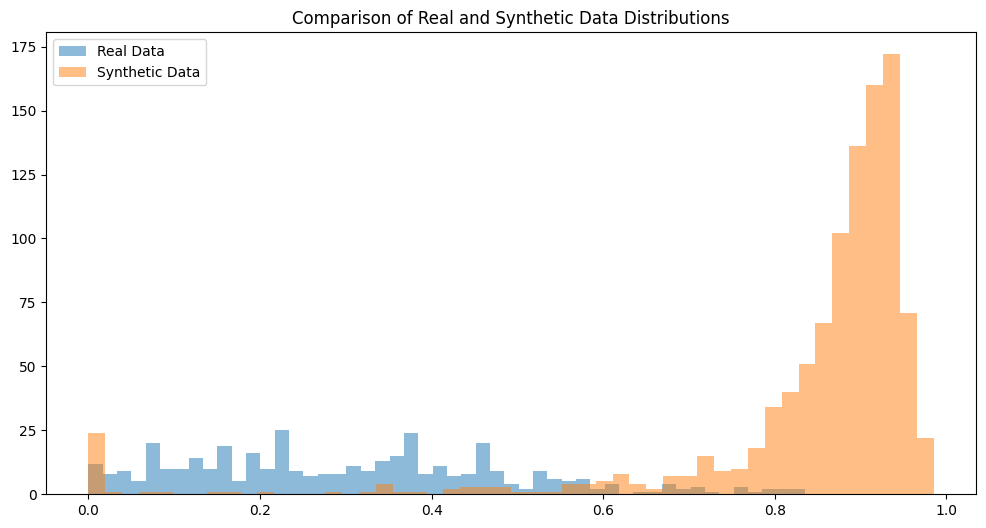

In [58]:
import matplotlib.pyplot as plt

# Assuming the last column is the label
real_features = test_data[:, :-1]
synthetic_features = synthetic_data[:, :-1]

# Example: Compare distributions for the first feature
plt.figure(figsize=(12, 6))
plt.hist(real_features[:, 0], bins=50, alpha=0.5, label='Real Data')
plt.hist(synthetic_data[:, 0], bins=50, alpha=0.5, label='Synthetic Data')
plt.legend()
plt.title('Comparison of Real and Synthetic Data Distributions')
plt.show()